# T-S comparison with obs

1) https://www.nature.com/articles/s41467-022-28751-5
2) https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019JC015133


For reference: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/TemperatureSalinityDiagrams.ipynb

In [40]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 140.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35323,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 140.00 GiB
Comm: tcp://127.0.0.1:34211,Total threads: 3
Dashboard: /proxy/36587/status,Memory: 35.00 GiB
Nanny: tcp://127.0.0.1:36185,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2155-01-01'

lat_slice = slice(-80,-59)
lon_slice = slice(-280,80)
#isobath_depth = 1000

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/hd4873/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004


0it [00:00, ?it/s]

Indexing experiment: accessom2-GPC005



0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

Get bathymetry. 

In [5]:
# get bathymetry
ht = cc.querying.getvar(control, 'ht', master_session, n=-1).sel(yt_ocean=lat_slice)

## Comparison with Yang et al. (2022)

Define observation points from Yang et al. (2022) - https://www.nature.com/articles/s41467-022-28751-5


In [6]:
#POINT 1 (K3)
lat3,lon3 = -74.171500,-112.528300
zmin3, zmax3 =  247, 1015
zlvls3 = [247, 317, 388, 468, 539, 610, 682, 752, 823, 894, 955, 1015]
#POINT 2 (K4)
lat4,lon4 = -74.176300,-112.134700
zmin4, zmax4 =  249, 747
zlvls4 = [249, 314, 385, 457, 527, 598, 675, 747]
#POINT 3 (K5)
lat5,lon5 = -74.182400,-113.063700
zmin5, zmax5 =  272, 768
zlvls5 = [272, 342, 412, 483, 553, 622, 695, 768]

Define functions to read in data from control and perturbations

In [114]:
def read_and_convert_TS(lat, lon, depth_lvls, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    lat = decimal latitude point
    lon = decimal longitude point
    depth_lvls = array of mooring instrument depths
    start_time = time string ('YYYY-MM-DD')
    end_time = time string ('YYYY-MM-DD')
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    # temp_Tfreeze_min run
    temp_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    # temp_Tfreeze_insituS run
    temp_Tfreeze_insituS = cc.querying.getvar(Tfreezing_insituS, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt_Tfreeze_insituS = cc.querying.getvar(Tfreezing_insituS, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    # temp_Tfreeze_insituS run
    temp_Tfreeze_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt_Tfreeze_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
 
    
    # interpolate to mooring depths and load data
    salt = salt.interp(st_ocean = depth_lvls).load()
    temp = temp.interp(st_ocean = depth_lvls).load()
    salt_Tfreeze_min = salt_Tfreeze_min.interp(st_ocean = depth_lvls).load()
    temp_Tfreeze_min = temp_Tfreeze_min.interp(st_ocean = depth_lvls).load()
    salt_Tfreeze_insituS = salt_Tfreeze_insituS.interp(st_ocean = depth_lvls).load()
    temp_Tfreeze_insituS = temp_Tfreeze_insituS.interp(st_ocean = depth_lvls).load()
    salt_Tfreeze_zeroS = salt_Tfreeze_zeroS.interp(st_ocean = depth_lvls).load()
    temp_Tfreeze_zeroS = temp_Tfreeze_zeroS.interp(st_ocean = depth_lvls).load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    temp_Tfreeze_min = temp_Tfreeze_min - 273.15
    temp_Tfreeze_insituS = temp_Tfreeze_insituS - 273.15
    temp_Tfreeze_zeroS = temp_Tfreeze_zeroS - 273.15
    
    # convert conservative temperature to potential temperature
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt_SA = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    salt_Tfreeze_min_SA = gsw.SA_from_SP(salt_Tfreeze_min, p, salt_Tfreeze_min.xt_ocean, salt_Tfreeze_min.yt_ocean)
    salt_Tfreeze_insituS_SA = gsw.SA_from_SP(salt_Tfreeze_insituS, p, salt_Tfreeze_insituS.xt_ocean, salt_Tfreeze_insituS.yt_ocean)
    salt_Tfreeze_zeroS_SA = gsw.SA_from_SP(salt_Tfreeze_zeroS, p, salt_Tfreeze_zeroS.xt_ocean, salt_Tfreeze_zeroS.yt_ocean)
    temp = gsw.conversions.pt_from_CT(salt_SA, temp)
    temp_Tfreeze_min = gsw.conversions.pt_from_CT(salt_Tfreeze_min_SA, temp_Tfreeze_min)
    temp_Tfreeze_insituS = gsw.conversions.pt_from_CT(salt_Tfreeze_insituS_SA, temp_Tfreeze_insituS)
    temp_Tfreeze_zeroS = gsw.conversions.pt_from_CT(salt_Tfreeze_zeroS_SA, temp_Tfreeze_zeroS)
    
    return temp,salt,temp_Tfreeze_min,salt_Tfreeze_min,temp_Tfreeze_insituS,salt_Tfreeze_insituS,temp_Tfreeze_zeroS,salt_Tfreeze_zeroS 


Define figure functions

In [154]:
def figure(region):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    sig_lvls = [27, 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28]
    for ax in axes.flatten():
        ax.set_ylim([-2,1])
        ax.set_xlim([33.8,34.7])
        ax.set_ylabel('Potential Temperature (C)')
        ax.set_xlabel('Salinity (psu)')
        cl = ax.contour(salt_mesh,temp_mesh,density_for_contouring, sig_lvls,colors='grey',linewidths=1, zorder=1)
        ax.clabel(cl, sig_lvls, colors='grey',zorder=1)
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.grid(which='both', linestyle='--', linewidth = 0.5)
        
    return fig, axes, region

# create density mesh for contours on T-S
temp_vals = np.arange(-2.5,1.2,.05)
salt_vals = np.arange(26,35.5,.005) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
density_for_contouring = gsw.density.rho(salt_mesh, temp_mesh, 1) - 1000
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

Read in data from model. 

In [151]:
%%time
start_time='2150-01-02'
end_time='2153-01-01'

temp3,salt3,temp_Tfreeze_min3,salt_Tfreeze_min3,temp_Tfreeze_insituS3,salt_Tfreeze_insituS3,temp_Tfreeze_zeroS3,salt_Tfreeze_zeroS3 = read_and_convert_TS(lat3, lon3, zlvls3, start_time, end_time)
temp4,salt4,temp_Tfreeze_min4,salt_Tfreeze_min4,temp_Tfreeze_insituS4,salt_Tfreeze_insituS4,temp_Tfreeze_zeroS4,salt_Tfreeze_zeroS4 = read_and_convert_TS(lat4, lon4, zlvls4, start_time, end_time)
temp5,salt5,temp_Tfreeze_min5,salt_Tfreeze_min5,temp_Tfreeze_insituS5,salt_Tfreeze_insituS5,temp_Tfreeze_zeroS5,salt_Tfreeze_zeroS5 = read_and_convert_TS(lat5, lon5, zlvls5, start_time, end_time)


Temp is 3.456e-06 GB
Temp is 2.304e-06 GB
Temp is 2.304e-06 GB
CPU times: user 20.5 s, sys: 827 ms, total: 21.4 s
Wall time: 38.8 s


#### Figure 1: Comparison with Figure 1d from paper. 

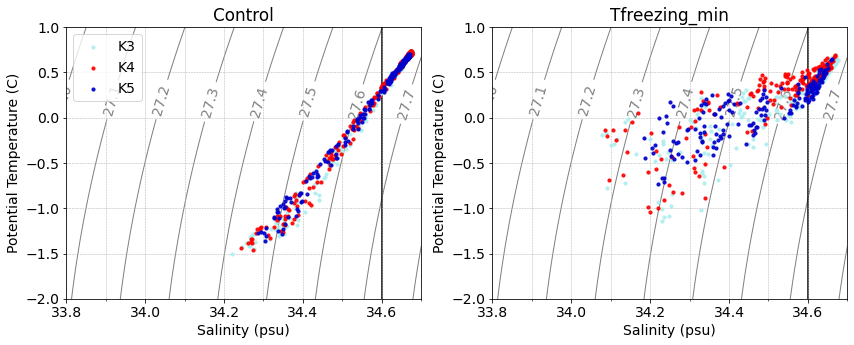

In [155]:
colours = ['paleturquoise','red','mediumblue']
s,alph = 10, 0.9

fig, axes, region = figure('Amundsen Sea comparison with Yang at al. (2022)')

axes[0].scatter(salt3, temp3, c=colours[0], s=s, alpha = alph, zorder=2, label='K3')
axes[0].scatter(salt4, temp4, c=colours[1], s=s, alpha = alph, zorder=2, label='K4')
axes[0].scatter(salt5, temp5, c=colours[2], s=s, alpha = alph, zorder=2, label='K5')
axes[0].set_title('Control')
axes[0].legend()
axes[0].plot([34.6, 34.6],[-3,1.5], c='k',zorder=1)

axes[1].scatter(salt_Tfreeze_min3, temp_Tfreeze_min3, c=colours[0], alpha = alph,  s=s, zorder=2,)
axes[1].scatter(salt_Tfreeze_min4, temp_Tfreeze_min4, c=colours[1],  alpha = alph, s=s, zorder=2,)
axes[1].scatter(salt_Tfreeze_min5, temp_Tfreeze_min5, c=colours[2],  alpha = alph, s=s, zorder=2,)
axes[1].set_title('Tfreezing_min')
axes[1].plot([34.6, 34.6],[-3,1.5], c='k',zorder=1)

plt.show()

#### Figure 2: Comparison with Figure 1e from paper. 

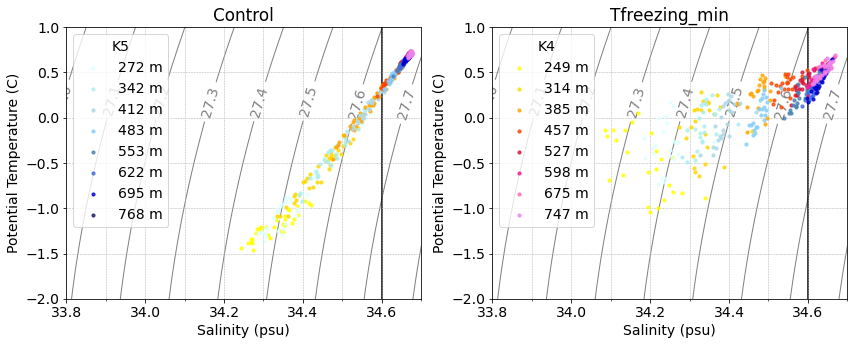

In [156]:
colours5 = ['lightcyan','paleturquoise','lightblue','lightskyblue','steelblue','royalblue','mediumblue','midnightblue']
colours4 = ['yellow','gold','orange','orangered','crimson','deeppink','hotpink','violet']
#labels = ['','','','','','','',']
s,alph = 10, 0.8

fig, axes, region = figure('Amundsen Sea comparison with Yang at al. (2022)')

for i in range(8):
    axes[0].scatter(salt4.isel(st_ocean=i), temp4.isel(st_ocean=i), c=colours4[i], s=s, alpha = alph, zorder=2)
    axes[0].scatter(salt5.isel(st_ocean=i), temp5.isel(st_ocean=i), c=colours5[i], s=s, alpha = alph, zorder=2, label=f'{temp5.isel(st_ocean=i).st_ocean.values} m')
axes[0].set_title('Control')
axes[0].legend(title='K5')
axes[0].plot([34.6, 34.6],[-3,1.5], c='k',zorder=1)

for i in range(8):
    axes[1].scatter(salt_Tfreeze_min4.isel(st_ocean=i), temp_Tfreeze_min4.isel(st_ocean=i), c=colours4[i], s=s, alpha = alph, zorder=2, label=f'{temp4.isel(st_ocean=i).st_ocean.values} m')
    axes[1].scatter(salt_Tfreeze_min5.isel(st_ocean=i), temp_Tfreeze_min5.isel(st_ocean=i), c=colours5[i], s=s, alpha = alph,zorder=2)
axes[1].set_title('Tfreezing_min')
axes[1].legend(title='K4')
axes[1].plot([34.6, 34.6],[-3,1.5], c='k',zorder=1)

plt.show()

# WORKING ------------

In [93]:
def figure_4subplot(region):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(1,4, figsize=(25,5))
    sig_lvls = [27, 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28]
    axes[0].set_ylabel('Potential Temperature (C)')
    for ax in axes.flatten():
        ax.set_ylim([-2,1])
        ax.set_xlim([33.8,34.7])
        #ax.set_ylabel('Potential Temperature (C)')
        ax.set_xlabel('Salinity (psu)')
        cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='dimgrey',linewidths=1)
        ax.clabel(cl, sig_lvls, colors='dimgrey')
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.grid(which='both', linestyle='--', linewidth = 0.5)
        
    return fig, axes, region

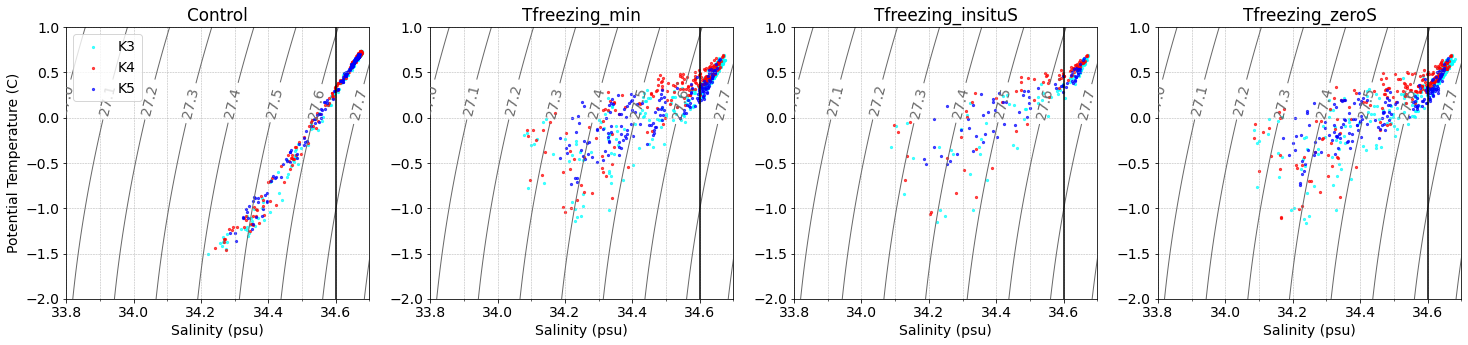

In [99]:
colours = ['cyan','red','blue']
s,alph = 5, 0.7

fig, axes, region = figure_4subplot('Amundsen Sea comparison with Yang at al. (2022)')

axes[0].scatter(salt3, temp3, c=colours[0], s=s, alpha = alph, label='K3')
axes[0].scatter(salt4, temp4, c=colours[1], s=s, alpha = alph, label='K4')
axes[0].scatter(salt5, temp5, c=colours[2], s=s, alpha = alph, label='K5')
axes[0].set_title('Control')
axes[0].legend()
axes[0].plot([34.6, 34.6],[-3,1.5], c='k')

axes[1].scatter(salt_Tfreeze_min3, temp_Tfreeze_min3, c=colours[0], alpha = alph,  s=s)
axes[1].scatter(salt_Tfreeze_min4, temp_Tfreeze_min4, c=colours[1],  alpha = alph, s=s)
axes[1].scatter(salt_Tfreeze_min5, temp_Tfreeze_min5, c=colours[2],  alpha = alph, s=s)
axes[1].set_title('Tfreezing_min')
axes[1].plot([34.6, 34.6],[-3,1.5], c='k')

axes[2].scatter(salt_Tfreeze_insituS3, temp_Tfreeze_insituS3, c=colours[0], alpha = alph,  s=s)
axes[2].scatter(salt_Tfreeze_insituS4, temp_Tfreeze_insituS4, c=colours[1],  alpha = alph, s=s)
axes[2].scatter(salt_Tfreeze_insituS5, temp_Tfreeze_insituS5, c=colours[2],  alpha = alph, s=s)
axes[2].set_title('Tfreezing_insituS')
axes[2].plot([34.6, 34.6],[-3,1.5], c='k')

axes[3].scatter(salt_Tfreeze_zeroS3, temp_Tfreeze_zeroS3, c=colours[0], alpha = alph,  s=s)
axes[3].scatter(salt_Tfreeze_zeroS4, temp_Tfreeze_zeroS4, c=colours[1],  alpha = alph, s=s)
axes[3].scatter(salt_Tfreeze_zeroS5, temp_Tfreeze_zeroS5, c=colours[2],  alpha = alph, s=s)
axes[3].set_title('Tfreezing_zeroS')
axes[3].plot([34.6, 34.6],[-3,1.5], c='k')

plt.show()

Density contours don't match those in the paper.... ???

Try interpolating onto 20m grid to get more datapoints. 

In [102]:
def read_and_convert_TS(lat, lon, depth_range, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    lat = decimal latitude point
    lon = decimal longitude point
    depth_lvls = array of mooring instrument depths
    start_time = time string ('YYYY-MM-DD')
    end_time = time string ('YYYY-MM-DD')
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    # temp_Tfreeze_min run
    temp_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    salt_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat, method='nearest').sel(xt_ocean=lon, method='nearest')#.sel(st_ocean=depth_slice)
    
    # interpolate to mooring depths and load data
    salt = salt.interp(st_ocean = np.arange(depth_range[0], depth_range[1], 20)).load()
    temp = temp.interp(st_ocean = np.arange(depth_range[0], depth_range[1], 20)).load()
    salt_Tfreeze_min = salt_Tfreeze_min.interp(st_ocean = np.arange(depth_range[0], depth_range[1], 20)).load()
    temp_Tfreeze_min = temp_Tfreeze_min.interp(st_ocean = np.arange(depth_range[0], depth_range[1], 20)).load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    temp_Tfreeze_min = temp_Tfreeze_min - 273.15
    
    # convert conservative temperature to potential temperature
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt_SA = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    salt_Tfreeze_min_SA = gsw.SA_from_SP(salt_Tfreeze_min, p, salt_Tfreeze_min.xt_ocean, salt_Tfreeze_min.yt_ocean)
    temp = gsw.conversions.pt_from_CT(salt_SA, temp)
    temp_Tfreeze_min = gsw.conversions.pt_from_CT(salt_Tfreeze_min_SA, temp_Tfreeze_min)
    
    return temp,salt,temp_Tfreeze_min,salt_Tfreeze_min


In [103]:
%%time
start_time='2150-01-02'
end_time='2152-01-01'

temp3, salt3, temp_Tfreeze_min3, salt_Tfreeze_min3 = read_and_convert_TS(lat3, lon3, [zmin3, zmax3], start_time, end_time)
temp4, salt4, temp_Tfreeze_min4, salt_Tfreeze_min4 = read_and_convert_TS(lat4, lon4, [zmin4, zmax4], start_time, end_time)
temp5, salt5, temp_Tfreeze_min5, salt_Tfreeze_min5 = read_and_convert_TS(lat5, lon5, [zmin5, zmax5], start_time, end_time)

2022-09-07 15:23:48,029 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:48,675 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:49,156 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-09-07 15:23:49,910 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:49,942 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-09-07 15:23:49,946 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:50,417 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-09-07 15:23:51,127 - distributed.utils_perf - WARNING - full garbage collections took

Temp is 7.488e-06 GB


2022-09-07 15:23:55,095 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:55,110 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:55,449 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-09-07 15:23:56,143 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-09-07 15:23:56,167 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:56,561 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-09-07 15:23:57,340 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:23:57,347 - distributed.utils_perf - WARNING - full garbage collections took

Temp is 4.8e-06 GB


2022-09-07 15:24:00,459 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-09-07 15:24:00,469 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:24:01,052 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-09-07 15:24:01,300 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:24:01,305 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:24:02,145 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:24:02,168 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-07 15:24:02,572 - distributed.utils_perf - WARNING - full garbage collections took

Temp is 4.8e-06 GB
CPU times: user 9.84 s, sys: 470 ms, total: 10.3 s
Wall time: 18.5 s


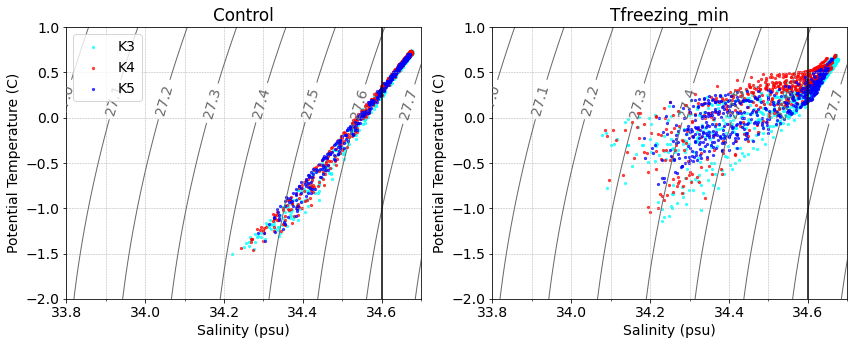

In [83]:
colours = ['cyan','red','blue']
s,alph = 5, 0.7

fig, axes, region = figure('Amundsen Sea comparison with Yang at al. (2022)')

axes[0].scatter(salt3, temp3, c=colours[0], s=s, alpha = alph, label='K3')
axes[0].scatter(salt4, temp4, c=colours[1], s=s, alpha = alph, label='K4')
axes[0].scatter(salt5, temp5, c=colours[2], s=s, alpha = alph, label='K5')
axes[0].set_title('Control')
axes[0].legend()
axes[0].plot([34.6, 34.6],[-3,1.5], c='k')

axes[1].scatter(salt_Tfreeze_min3, temp_Tfreeze_min3, c=colours[0], alpha = alph,  s=s)
axes[1].scatter(salt_Tfreeze_min4, temp_Tfreeze_min4, c=colours[1],  alpha = alph, s=s)
axes[1].scatter(salt_Tfreeze_min5, temp_Tfreeze_min5, c=colours[2],  alpha = alph, s=s)
axes[1].set_title('Tfreezing_min')
axes[1].plot([34.6, 34.6],[-3,1.5], c='k')

plt.show()